# Modèle sur mesure avancé

### Sommaire
1. [Collection des données venant d’une API qui correspondent à un besoin défini](#paragraph1)</p> 
1. [Analyse exploratoire des données textes](#paragraph1)</p> 
    1.1. [Visualisation des variables R, F et M](#subparagraph1_1)</p> 
2. [Pré-traitement de données textes](#paragraph2)</p>
    2.1. [Clustering Kmeans sur les données RFM](#subparagraph2_1)</p> 
    2.2. [Clusterig hiérarchique sur les données RFM](#subparagraph2_2)</p>
    2.3. [Clusterinhg DBSCAN sur les données RFM](#subparagraph2_3)</p>
3. [Analyse de sentiment](#paragraph3)</p> 
    3.1. [Kmeans sur les données RFM+](#subparagraph3_1)</p> 
4. [Modélisation de sujets](#paragraph3)</p> 

In [3]:
import sys
sys.path.append('../src')  # Add the src folder to the module search path
from utils import Utils

import os
import matplotlib.pyplot as plt
import seaborn as sns

# Maths modules
#from scipy.stats import f_oneway
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression


# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, Embedding, Bidirectional
from tensorflow.keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

# tuning hyp parameters
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperModel

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\doly9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\doly9\AppData\Local\Temp\ipykernel_8944\1272960418.py:33: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


## Charger des données nettoyées à partir d'un fichier CSV

In [4]:
df = pd.read_csv('D:/openclassroom/projet7/input/df_cleaned_docs.csv',encoding='ISO-8859-1')

In [5]:
df.shape

(1597489, 3)

In [6]:
df.head()

,target,text,clean_text
0,NEGATIVE,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot httptwitpiccom awww s bummer should...
1,NEGATIVE,is upset that he can't update his Facebook by ...,upset not update facebook texte cry result sch...
2,NEGATIVE,@Kenichan I dived many times for the ball. Man...,kenichan dive time ball manage save rest bound
3,NEGATIVE,my whole body feels itchy and like its on fire,body feel itchy like fire
4,NEGATIVE,"@nationwideclass no, it's not behaving at all....",nationwideclass behave m mad not


In [7]:
# split text column into lists of words
df["tokenized_tweet"] = df['clean_text'].str.split()

In [8]:
df.head()

,target,text,clean_text,tokenized_tweet
0,NEGATIVE,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot httptwitpiccom awww s bummer should...,"[switchfoot, httptwitpiccom, awww, s, bummer, ..."
1,NEGATIVE,is upset that he can't update his Facebook by ...,upset not update facebook texte cry result sch...,"[upset, not, update, facebook, texte, cry, res..."
2,NEGATIVE,@Kenichan I dived many times for the ball. Man...,kenichan dive time ball manage save rest bound,"[kenichan, dive, time, ball, manage, save, res..."
3,NEGATIVE,my whole body feels itchy and like its on fire,body feel itchy like fire,"[body, feel, itchy, like, fire]"
4,NEGATIVE,"@nationwideclass no, it's not behaving at all....",nationwideclass behave m mad not,"[nationwideclass, behave, m, mad, not]"


In [9]:
df.shape

(1597489, 4)

## Encodage en entiers des documents
Cela permet de préparer les données textuelles pour une utilisation dans un modèle Keras pour la classification de texte.

In [10]:
#Converting all tokenized words into constant numbers: Tokenize the words
texts = df['clean_text']
tokenizer = Tokenizer(nb_words=14225)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

C:\Users\doly9\AppData\Roaming\Python\Python311\site-packages\keras\preprocessing\text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


In [11]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
num_words = len(word_index) +1

Found 697834 unique tokens.


In [12]:
# Pad sequences to a fixed length
data = pad_sequences(sequences, maxlen=30)
data_length = data.shape[1]
labels = df['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (1597489, 30)
Shape of label tensor: (1597489,)


## Embedding methods

In [13]:
# The function would return a new embedding matrix that has the loaded weights from the pretrained embeddings for the common words we have
embedding_dim = 100
def create_embedding_matrix(embedding_method, word_index, sentences, embedding_dim=100):
    
    
    embedding_matrix = np.zeros((num_words, embedding_dim))
    embeddings_index = {}
    
    if(embedding_method=="glove"):
        glove_path = os.path.join("..", "inputs")
        with open(glove_path+'/glove.6B.100d.txt',encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        print('Loaded %s word vectors.' % len(embeddings_index))
            
    elif(embedding_method=="word2vec"):
        word2vec = Word2Vec(sentences, vector_size = embedding_dim, window = 20, min_count = 2, negative = 20)
        for word in word2vec.wv.index_to_key:
            embeddings_index[word] = word2vec.wv[word]
        print('Loaded %s word vectors.' % len(embeddings_index))
            
    #Maintenant, nous allons créer notre matrice d'embedding :
    embeddedCount = 0
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            embeddedCount+=1
            
    print('total embedded:',embeddedCount,'common words')
    
    del(embeddings_index)
    
    return embedding_matrix

In [14]:
glove_embedding_matrix = create_embedding_matrix("glove", word_index, df.tokenized_tweet)

Loaded 400000 word vectors.
total embedded: 87002 common words


In [15]:
glove_embedding_matrix.shape

(697835, 100)

In [16]:
word2vec_embedding_matrix = create_embedding_matrix("word2vec", word_index, df.tokenized_tweet)

Loaded 219147 word vectors.
total embedded: 218915 common words


In [17]:
word2vec_embedding_matrix.shape

(697835, 100)

In [18]:
glove_layer =Embedding(input_dim=glove_embedding_matrix.shape[0], output_dim=glove_embedding_matrix.shape[1], weights=[glove_embedding_matrix], trainable=False)
word2vec_layer =Embedding(input_dim=word2vec_embedding_matrix.shape[0], output_dim=word2vec_embedding_matrix.shape[1], weights=[word2vec_embedding_matrix], trainable=False)


## Séparer un jeu de données en un jeu d'entraînement, un jeu de validation et un jeu de test

In [19]:
X = data
y = df['target'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

# Séparer le jeu de données en un jeu d'entraînement (70%), un jeu de validation (20%) et un jeu de test (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val,X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

# Vérifier la taille des jeux de données
print("Taille du jeu d'entraînement :", X_train.shape)
print("Taille du jeu de validation :", X_val.shape)
print("Taille du jeu de test :", X_test.shape)

Taille du jeu d'entraînement : (1118242, 30)
Taille du jeu de validation : (321095, 30)
Taille du jeu de test : (158152, 30)


## Hyperparameter tuning for models.

Pour créer une couche d'embedding dans un modèle Keras pour la classification de texte, on utilise les vecteurs de mots appris à partir d'un modèle Word2Vec entraîné sur un corpus de textes.

- input_dim : la taille du vocabulaire du modèle Word2Vec

- output_dim :  la taille de chaque vecteur de mots du modèle Word2Vec

- Les weights sont initialisés avec les vecteurs de mots appris par le modèle Word2Vec, 

- Le paramètre trainable=False signifie que ces poids ne seront pas mis à jour pendant l'entraînement du modèle Keras (car les vecteurs ont déjà été appris par le modèle Word2Vec).

Cette couche d'embedding est utilisée pour transformer les séquences de mots d'un texte en vecteurs denses de dimension output_dim, qui sont ensuite utilisés pour entraîner un modèle de classification de texte

class MyHyperModel(HyperModel):

    def __init__(self, name_model, layer_embedding):
        self.name_model = name_model
        self.layer_embedding = layer_embedding

    def build(self, hp):
        model_nn = Sequential(name=self.name_model)
        model_nn.add(self.layer_embedding)
        #e = Embedding(input_dim=model_word2Vec.wv.vectors.shape[0], output_dim=model_word2Vec.wv.vectors.shape[1], weights=[model_word2Vec.wv.vectors], trainable=False)
        #model_nn.add(e)
        model_nn.add(LSTM(units=hp.Int('units_lstm', min_value=20, max_value=100, step=20), dropout=0.2))
        model_nn.add(Dense(units=hp.Int('units_dense_', min_value=10, max_value=50, step=20),activation='relu'))
        model_nn.add(Dense(1, activation='sigmoid'))
        model_nn.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy', AUC(curve="ROC", name="ROC_AUC")])
        return model_nn

class MyHyperModel(HyperModel):

    def __init__(self, name_model, layer_embedding):
        self.name_model = name_model
        self.layer_embedding = layer_embedding

    def build(self, hp):
        model_nn = Sequential(name=self.name_model)
        model_nn.add(self.layer_embedding)
        #e = Embedding(input_dim=model_word2Vec.wv.vectors.shape[0], output_dim=model_word2Vec.wv.vectors.shape[1], weights=[model_word2Vec.wv.vectors], trainable=False)
        #model_nn.add(e)
        model_nn.add(LSTM(units=hp.Int('units_lstm', min_value=20, max_value=100, step=20), dropout=0.2))
        model_nn.add(Dense(units=hp.Int('units_dense_', min_value=10, max_value=50, step=20),activation='relu'))
        model_nn.add(Dense(1, activation='sigmoid'))
        model_nn.compile(optimizer=hp.Choice('optimizer', values= ['Adam', 'Adadelta']),
                    loss='binary_crossentropy', metrics=['accuracy', AUC(curve="ROC", name="ROC_AUC")])
        return model_nn

In [22]:
class MyHyperModel(HyperModel):

    def __init__(self, name_model, layer_embedding,type_model):
        self.name_model = name_model
        self.layer_embedding = layer_embedding
        self.type_model = type_model

    def build(self, hp):
        model_nn = Sequential(name=self.name_model)
        model_nn.add(self.layer_embedding)
        if (self.type_model=='LSTM'):
            model_nn.add(LSTM(units=hp.Int('units_lstm', min_value=20, max_value=100, step=20), dropout=0.2))
        if (self.type_model=='BidirectionalLSTM'):
            model_nn.add(Bidirectional(LSTM(units=hp.Int('units_lstm', min_value=20, max_value=100, step=20), dropout=0.2)))
        model_nn.add(Dense(units=hp.Int('units_dense_', min_value=10, max_value=50, step=20),activation='relu'))
        model_nn.add(Dense(1, activation='sigmoid'))
        model_nn.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy', AUC(curve="ROC", name="ROC_AUC")])
        return model_nn

In [41]:
#word2vec_layer =Embedding(input_dim=model_word2Vec.wv.vectors.shape[0], output_dim=model_word2Vec.wv.vectors.shape[1], weights=[model_word2Vec.wv.vectors], trainable=False)

#hypermodel = MyHyperModel("lstm_word2vec_embedding", word2vec_layer,"LSTM")
hypermodel = MyHyperModel("bilstm_word2vec_embedding", word2vec_layer,"BidirectionalLSTM")

tuner = BayesianOptimization(hypermodel, objective='val_accuracy', max_trials=10, overwrite=True)
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=1024)


Trial 10 Complete [00h 43m 44s]
val_accuracy: 0.7609710693359375

Best val_accuracy So Far: 0.7651878595352173
Total elapsed time: 05h 50m 09s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Hyperparamer tuner
#glove_layer = Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)
#glove_hypermodel = MyHyperModel("lstm_glove_embedding", glove_layer,"LSTM")
#glove_tuner = BayesianOptimization(glove_hypermodel, objective='val_accuracy', max_trials=10)
#glove_tuner.search(X_train, y_train, epochs=3, validation_data=(X_val, y_val), batch_size=1024)


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)
best_model.summary()

In [ ]:
# save the best model
results_data_path = os.path.join("..", "outputs")
model_save_path = os.path.join(results_data_path, "best_word2vec_lstm.h5")
best_model.save(model_save_path)

## Entrainement de modèle avec les meilleurs hyperparametères 

In [19]:

def create_model(name_model,type_model,layer_embedding,units_lstm,units_dense,opt):
    model_nn = Sequential(name=name_model)
    model_nn.add(layer_embedding)
    if (type_model=='LSTM'):
        model_nn.add(LSTM(units=units_lstm, dropout=0.2))
    if (type_model=='BidirectionalLSTM'):
        model_nn.add(Bidirectional(LSTM(units=units_lstm, dropout=0.2)))
    model_nn.add(Dense(units=units_dense,activation='relu'))
    model_nn.add(Dense(1, activation='sigmoid'))
    print(model_nn.summary())
    model_nn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', AUC(curve="ROC", name="ROC_AUC")])
    return model_nn

def train_model(model,epochs,batch_size,save_interval):
    checkpoint_callback = ModelCheckpoint(filepath=os.path.join("..", "saved_models")+'/'+model.name+'/'+model.name+'_epoch_{epoch:02d}.h5', save_freq=save_interval)
    tensorboard_callback = TensorBoard(log_dir=os.path.join("..", "logs")+'/'+model.name)
    history = model_nn.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=epochs, batch_size=batch_size, callbacks=[tensorboard_callback, checkpoint_callback])


In [128]:
name_model = "glove_bilstm"
type_model ="BidirectionalLSTM"
#layer_embedding = Embedding(input_dim=model_word2Vec.wv.vectors.shape[0], output_dim=model_word2Vec.wv.vectors.shape[1], weights=[model_word2Vec.wv.vectors], trainable=False)
layer_embedding =  Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[glove_embedding_matrix], trainable=False)
units_lstm = 100
units_dense = 10
opt = "adam"
epoch = 30
batch_size = 1024
save_interval = 5
model_nn = create_model(name_model,type_model,layer_embedding,units_lstm,units_dense,opt)
train_model(model_nn,epoch,batch_size,save_interval)

Model: "glove_bilstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         69783500  
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 10)                2010      
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 69,946,321
Trainable params: 162,821
Non-trainable params: 69,783,500
_________________________________________________________________
None
Epoch 1/30
1093/1093 [==============================] - 676s 611ms/step - loss: 0.5325 - accuracy

**Continue training a saved model from a specific epoch**

In [29]:
# load model
from keras.models import load_model
# Load the saved model
save_interval=5
model = load_model(os.path.join("..", "saved_models/glove_lstm/")+'glove_lstm_epoch_05.h5')
checkpoint_callback = ModelCheckpoint(filepath=os.path.join("..", "saved_models")+'/'+model.name+'/'+model.name+'_epoch_{epoch:02d}.h5', save_freq=save_interval)
tensorboard_callback = TensorBoard(log_dir=os.path.join("..", "logs")+'/'+model.name)
# Set the epoch number to start training from
initial_epoch = 5
# Continue training the model from initial_epoch 
model.fit(X_train, y_train, epochs=50, batch_size=1024, validation_data=(X_val, y_val), initial_epoch=initial_epoch,callbacks=[tensorboard_callback, checkpoint_callback])


Epoch 6/50
1093/1093 [==============================] - 287s 261ms/step - loss: 0.4846 - accuracy: 0.7643 - ROC_AUC: 0.8463 - val_loss: 0.4827 - val_accuracy: 0.7660 - val_ROC_AUC: 0.8527
Epoch 7/50
1093/1093 [==============================] - 284s 260ms/step - loss: 0.4820 - accuracy: 0.7659 - ROC_AUC: 0.8482 - val_loss: 0.4727 - val_accuracy: 0.7728 - val_ROC_AUC: 0.8553
Epoch 8/50
1093/1093 [==============================] - 297s 272ms/step - loss: 0.4797 - accuracy: 0.7677 - ROC_AUC: 0.8498 - val_loss: 0.4717 - val_accuracy: 0.7727 - val_ROC_AUC: 0.8561
Epoch 9/50
1093/1093 [==============================] - 288s 263ms/step - loss: 0.4778 - accuracy: 0.7688 - ROC_AUC: 0.8512 - val_loss: 0.4703 - val_accuracy: 0.7738 - val_ROC_AUC: 0.8568
Epoch 10/50
1093/1093 [==============================] - 306s 280ms/step - loss: 0.4761 - accuracy: 0.7698 - ROC_AUC: 0.8523 - val_loss: 0.4692 - val_accuracy: 0.7752 - val_ROC_AUC: 0.8574
Epoch 11/50
1093/1093 [==============================] - 29

KeyboardInterrupt: 

**Load model and retrain**

In [79]:
# load model
from keras.models import load_model
model_path = os.path.join("..", "saved_models")
model_save_path = os.path.join(model_path, "word2vec_lstm_epoch_30.h5")
loaded_model = load_model(model_save_path)

In [80]:
loaded_model.summary()


Model: "word2vec_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         69783500  
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 69,869,001
Trainable params: 85,501
Non-trainable params: 69,783,500
_________________________________________________________________


In [ ]:
# retrain
logdir = os.path.join("..", "logs/",model_nn.name)

tensorboard_callback = TensorBoard(log_dir=logdir)
#history = model_nn.fit(X_train, y_train, validation_split=0.2,epochs=10, batch_size=512, callbacks=[tensorboard_callback])
history = model_nn.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=10, batch_size=512, callbacks=[tensorboard_callback])


In [93]:
df.head()

,target,text,clean_text,tokenized_tweet
0,NEGATIVE,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot httptwitpiccom awww s bummer should...,"[switchfoot, httptwitpiccom, awww, s, bummer, ..."
1,NEGATIVE,is upset that he can't update his Facebook by ...,upset not update facebook texte cry result sch...,"[upset, not, update, facebook, texte, cry, res..."
2,NEGATIVE,@Kenichan I dived many times for the ball. Man...,kenichan dive time ball manage save rest bound,"[kenichan, dive, time, ball, manage, save, res..."
3,NEGATIVE,my whole body feels itchy and like its on fire,body feel itchy like fire,"[body, feel, itchy, like, fire]"
4,NEGATIVE,"@nationwideclass no, it's not behaving at all....",nationwideclass behave m mad not,"[nationwideclass, behave, m, mad, not]"


In [95]:
df.loc[2,"text"]

'@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'

In [98]:
y_pred_proba = loaded_model.predict(X_train)

34946/34946 [==============================] - 380s 11ms/step


In [101]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  132,
       1467, 1425, 2486,  560,  107, 1235,   12,   44])

**Analyse des performances du modèle**

In [107]:
# Example sentence for prediction
test_sentence = "the film is boring"


#tokenizer = Tokenizer(nb_words=14225)
#tokenizer.fit_on_texts([test_sentence])
# Convert test sentence to sequence
test_sequence = tokenizer.texts_to_sequences([test_sentence])
padded_test_sequence = pad_sequences(test_sequence, maxlen=30)
print(padded_test_sequence)

# Predict the sentiment of the test sentence
prediction = loaded_model.predict(padded_test_sequence)[0][0]
sentiment = "Positive" if prediction > 0.5 else "Negative"

print(f"Test sentence: {test_sentence}")
print(f"Sentiment: {sentiment} (Probability: {prediction:.4f})")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0 550 443]]
1/1 [==============================] - 0s 22ms/step
Test sentence: the film is boring
Sentiment: Negative (Probability: 0.0480)


34946/34946 [==============================] - 409s 12ms/step


<Figure size 640x480 with 0 Axes>

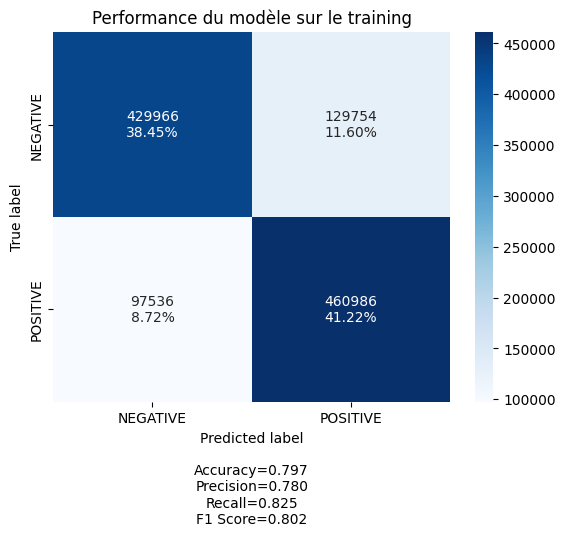

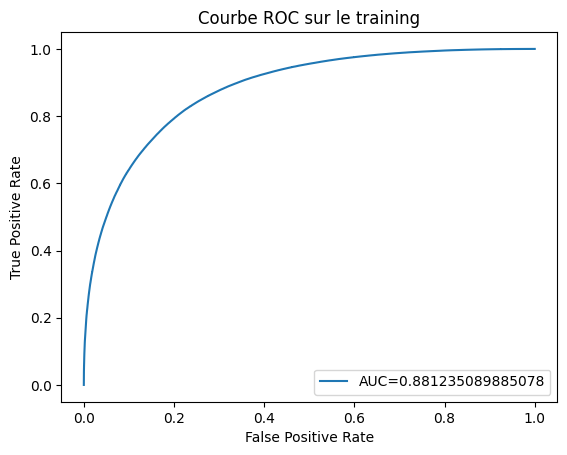

In [81]:
analyse_performance_model(loaded_model,X_train,y_train,"training")

10035/10035 [==============================] - 114s 11ms/step


<Figure size 640x480 with 0 Axes>

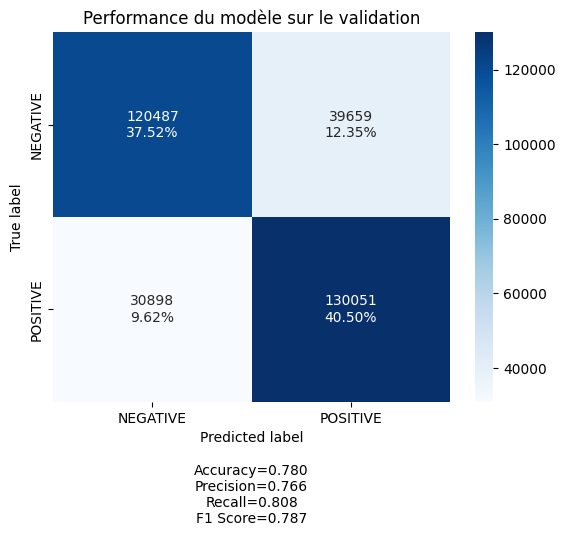

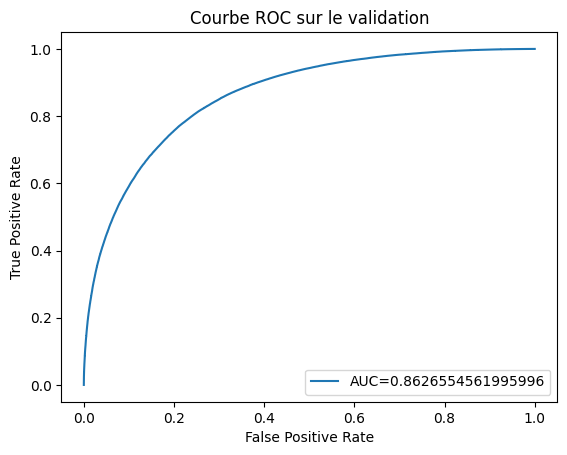

In [82]:
analyse_performance_model(loaded_model,X_val,y_val,"validation")

4943/4943 [==============================] - 48s 10ms/step


<Figure size 640x480 with 0 Axes>

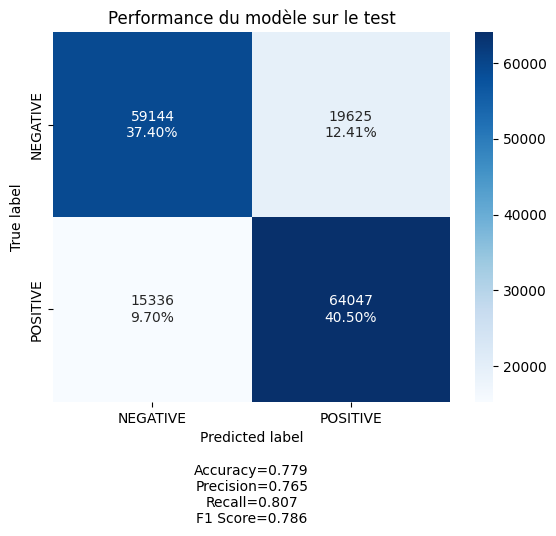

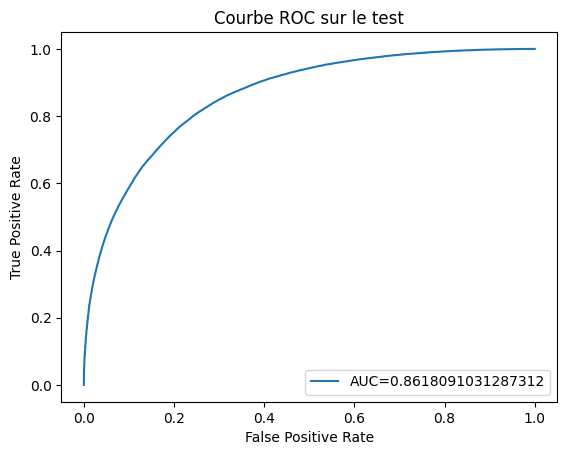

In [83]:
analyse_performance_model(loaded_model,X_test,y_test,"test")

**Glove LSTM model**

In [41]:
# Hyperparamer tuner
glove_layer = Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)
glove_hypermodel = MyHyperModel("lstm_glove_embedding", glove_layer,"LSTM")
glove_tuner = BayesianOptimization(glove_hypermodel, objective='val_accuracy', max_trials=10)
glove_tuner.search(X_train, y_train, epochs=3, validation_data=(X_val, y_val), batch_size=1024)


Trial 10 Complete [00h 06m 15s]
val_accuracy: 0.7574175596237183

Best val_accuracy So Far: 0.7646552920341492
Total elapsed time: 01h 18m 35s
INFO:tensorflow:Oracle triggered exit


In [42]:
best_model = glove_tuner.get_best_models(num_models=1)[0]
best_hyperparameters = glove_tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)
best_model.summary()

{'units_lstm': 80, 'units_dense_': 30, 'optimizer': 'Adam'}
Model: "lstm_glove_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         69783500  
                                                                 
 lstm (LSTM)                 (None, 80)                57920     
                                                                 
 dense (Dense)               (None, 30)                2430      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 69,843,881
Trainable params: 60,381
Non-trainable params: 69,783,500
_________________________________________________________________


In [45]:
model_save_path = os.path.join(results_data_path, "best_glove_lstm.h5")
best_model.save(model_save_path)

34946/34946 [==============================] - 281s 8ms/step


<Figure size 640x480 with 0 Axes>

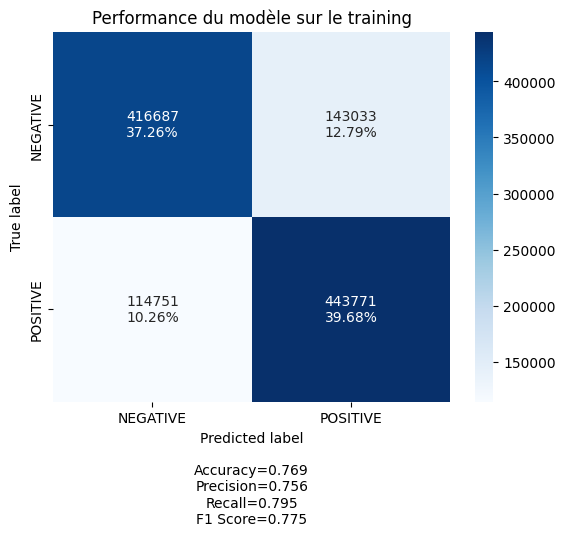

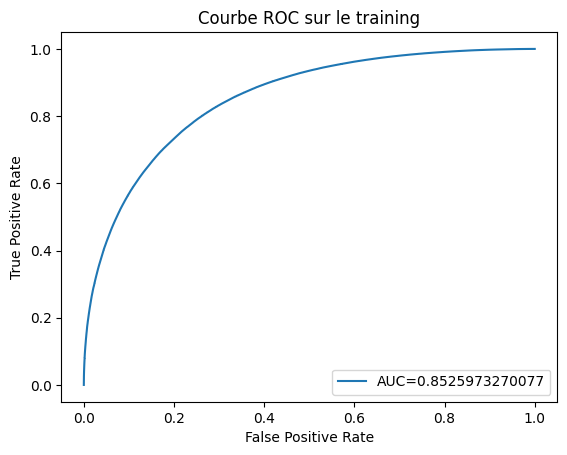

In [31]:
analyse_performance_model(best_model,X_train,y_train,"training")

10035/10035 [==============================] - 78s 8ms/step


<Figure size 640x480 with 0 Axes>

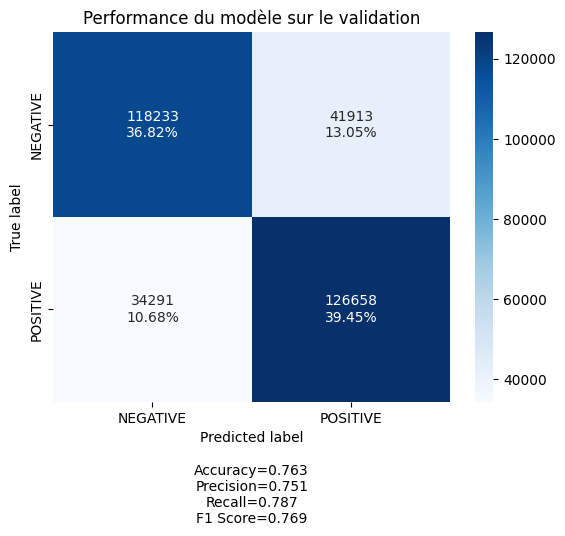

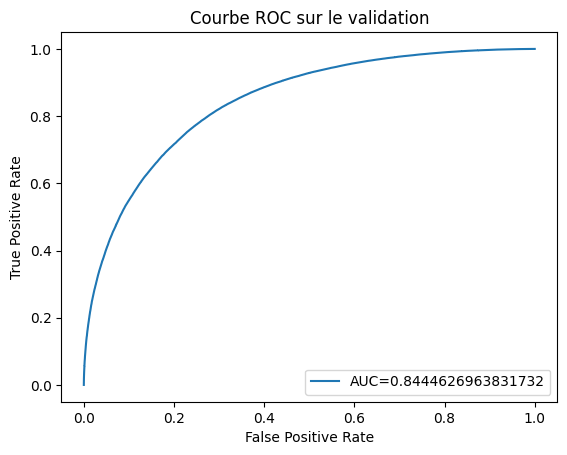

In [32]:
analyse_performance_model(best_model,X_val,y_val,"validation")

4943/4943 [==============================] - 44s 9ms/step


<Figure size 640x480 with 0 Axes>

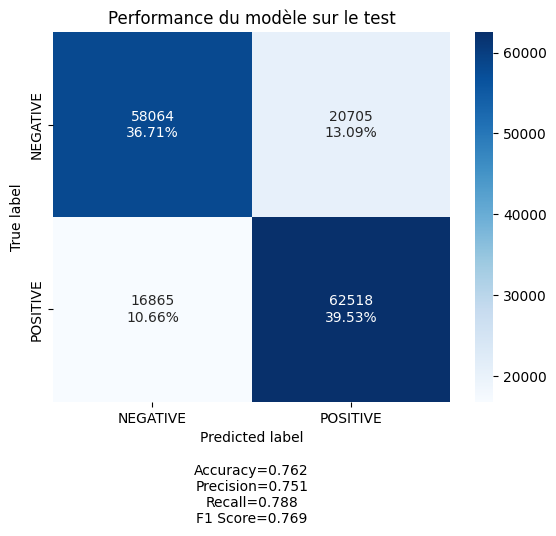

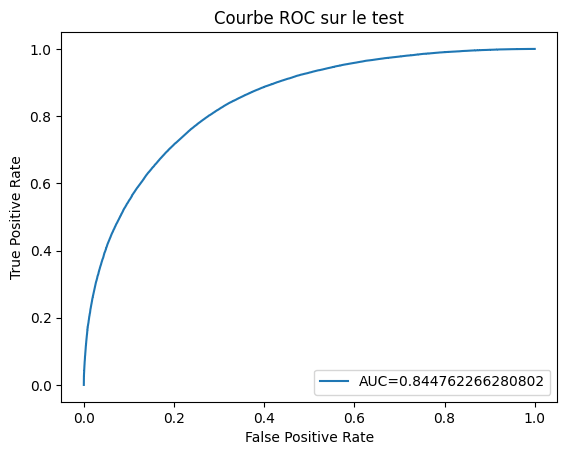

In [33]:
analyse_performance_model(best_model,X_test,y_test,"test")

# Utiliser l’outil MLFlow, 
 pour assurer la gestion des expérimentations des modèles : tracking et reporting de l’entraînement des modèles, centralisation du stockage des modèles, et test du serving proposé par MLFlow, 

In [ ]:
def create_model(name_model,type_model,layer_embedding,units_lstm,units_dense,opt):
    model_nn = Sequential(name=name_model)
    model_nn.add(layer_embedding)
    if (type_model=='LSTM'):
        model_nn.add(LSTM(units=units_lstm, dropout=0.2))
    if (type_model=='BidirectionalLSTM'):
        model_nn.add(Bidirectional(LSTM(units=units_lstm, dropout=0.2)))
    model_nn.add(Dense(units=units_dense,activation='relu'))
    model_nn.add(Dense(1, activation='sigmoid'))
    print(model_nn.summary())
    model_nn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', AUC(curve="ROC", name="ROC_AUC")])
    return model_nn

def train_model(model,epochs,batch_size,save_interval):
    checkpoint_callback = ModelCheckpoint(filepath=os.path.join("..", "saved_models")+'/'+model.name+'/'+model.name+'_epoch_{epoch:02d}.h5', save_freq=save_interval)
    tensorboard_callback = TensorBoard(log_dir=os.path.join("..", "logs")+'/'+model.name)
    history = model_nn.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=epochs, batch_size=batch_size, callbacks=[tensorboard_callback, checkpoint_callback])


In [51]:
import mlflow.keras as mlk
class AdvancedModel():
    def __init__(self, name_model,type_model,layer_embedding,units_lstm,units_dense, X_train, y_train):
        self.name_model = name_model
        self.type_model = type_model
        self.layer_embedding =layer_embedding
        self.units_lstm = units_lstm
        self.units_dense = units_dense
        self.X_train = X_train
        self.y_train = y_train
    
    def build(self):
        self.model_nn = Sequential(name=self.name_model)
        self.model_nn.add(self.layer_embedding)
        if (self.type_model=='LSTM'):
            self.model_nn.add(LSTM(units=self.units_lstm, dropout=0.2))
        if (self.type_model=='BidirectionalLSTM'):
            self.model_nn.add(Bidirectional(LSTM(units=self.units_lstm, dropout=0.2)))
        self.model_nn.add(Dense(units=self.units_dense,activation='relu'))
        self.model_nn.add(Dense(1, activation='sigmoid'))
        print(self.model_nn.summary())
        self.model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(curve="ROC", name="ROC_AUC")])

    def mlflow_run(self, epochs, batch_size):
        with mlflow.start_run(run_name=self.name_model) as run:
            # Automatically capture the model's parameters, metrics, artifacts,
            # and source code with the autolog() function
            mlk.autolog()
                # Enregistrez les paramètres
            mlflow.log_param("units_lstm", self.units_lstm)
            mlflow.log_param("units_dense", self.units_dense)
            history = self.model_nn.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=epochs, batch_size=batch_size)
        return run.info.run_id

In [52]:
import mlflow

if __name__ == "__main__":
    # create the model
    model_name = "Bidirectional-LSTM"
    experiment_name = "p7-advanced model"

    # Use sqlite:///mlruns.db as the local store for tracking and registery
    mlflow.set_tracking_uri("sqlite:///mlruns.db")

    name_model = "glove_lstm"
    type_model ="LSTM"
    #layer_embedding = Embedding(input_dim=model_word2Vec.wv.vectors.shape[0], output_dim=model_word2Vec.wv.vectors.shape[1], weights=[model_word2Vec.wv.vectors], trainable=False)
    layer_embedding =  Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[glove_embedding_matrix], trainable=False)
    units_lstm = 100
    units_dense = 50
    opt = "adam"
    epoch = 1
    batch_size = 1024

    model = AdvancedModel(name_model,type_model,layer_embedding,units_lstm,units_dense, X_train, y_train)
    model.build()
    run_id = model.mlflow_run(epoch,batch_size)
    print("MLflow run_id={}".format(run_id))


Model: "glove_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 100)         69783500  
                                                                 
 lstm_17 (LSTM)              (None, 100)               80400     
                                                                 
 dense_32 (Dense)            (None, 50)                5050      
                                                                 
 dense_33 (Dense)            (None, 1)                 51        
                                                                 
Total params: 69,869,001
Trainable params: 85,501
Non-trainable params: 69,783,500
_________________________________________________________________
None
1/1 [==============================] - 1s 552ms/step


WARNI [absl] Found untraced functions such as _update_step_xla, lstm_cell_17_layer_call_fn, lstm_cell_17_layer_call_and_return_conditional_losses while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: C:\Users\doly9\AppData\Local\Temp\tmp_tvch2ln\model\data\model\assets


INFO  [tensorflow] Assets written to: C:\Users\doly9\AppData\Local\Temp\tmp_tvch2ln\model\data\model\assets


MLflow run_id=f84cf82e945c4eed9d456adfeb9be28b


In [ ]:
# set up MLflow to track the metrics
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
mlflow.set_experiment(experiment_name)
mlflow.autolog()

model_nn = create_model(name_model,type_model,layer_embedding,units_lstm,units_dense,opt)

# Use sqlite:///mlruns.db as the local store for tracking and registery
#mlflow.set_tracking_uri("sqlite:///mlruns.db")

# train the model
with mlflow.start_run() as run:
    # Enregistrez les paramètres
    mlflow.log_param("units_lstm", units_lstm)
    mlflow.log_param("units_dense", units_dense)
    mlflow.log_param("batch_size", batch_size)

    # fit NN model
    train_model(model_nn,epoch,batch_size,save_interval)

    # register the model
    model_uri = "runs:/{}/model".format(run.info.run_id)
    model = mlflow.register_model(model_uri, name_model)

In [15]:
import zipfile
import h5py
import io

# Chemin vers le fichier compressé
chemin_fichier_comprime = "C:/Users/doly9/Projet7-Detect-bad-buzz-with-deep-learning/inputs/word2vec_lstm_epoch_30.zip"

# Nom du fichier modèle à l'intérieur du fichier compressé
nom_fichier_modele = "word2vec_lstm_epoch_30.h5"

# Charger votre modèle à partir du dossier compressé
with zipfile.ZipFile(chemin_fichier_comprime, 'r') as zip_ref:
    with zip_ref.open(nom_fichier_modele) as fichier_modele:
        # Utilisez la bibliothèque/framework approprié pour charger votre modèle à partir de "fichier_modele"
        # Par exemple, si vous utilisez Keras/TensorFlow :
        from keras.models import load_model
        
        # Charger le modèle depuis le fichier compressé
        modele = load_model(io.BytesIO(fichier_modele.read()))

OSError: Unable to load model. Filepath is not an hdf5 file (or h5py is not available) or SavedModel. Received: filepath=<_io.BytesIO object at 0x0000018A47428AE0>

In [11]:
modele.summary()


AttributeError: 'File' object has no attribute 'summary'

In [20]:
# load model
from keras.models import load_model
# Load the saved model
model = load_model(os.path.join("..","saved_models/")+'words2vec_lstm_epoch_50.h5')

In [21]:
model.summary()

Model: "words2vec_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         21914700  
                                                                 
 lstm_12 (LSTM)              (None, 80)                57920     
                                                                 
 dense_24 (Dense)            (None, 20)                1620      
                                                                 
 dense_25 (Dense)            (None, 1)                 21        
                                                                 
Total params: 21,974,261
Trainable params: 59,561
Non-trainable params: 21,914,700
_________________________________________________________________


In [23]:
Utils.analyse_performance_model(model,X_test,y_test,"test")

4943/4943 [==============================] - 38s 8ms/step


NameError: name 'np' is not defined

34946/34946 [==============================] - 223s 6ms/step


<Figure size 640x480 with 0 Axes>

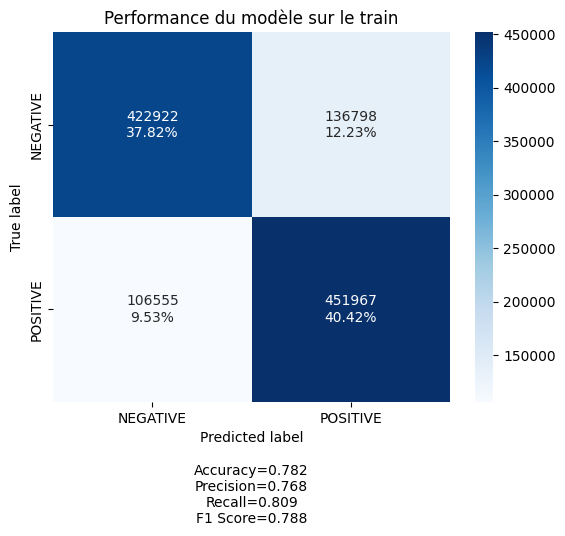

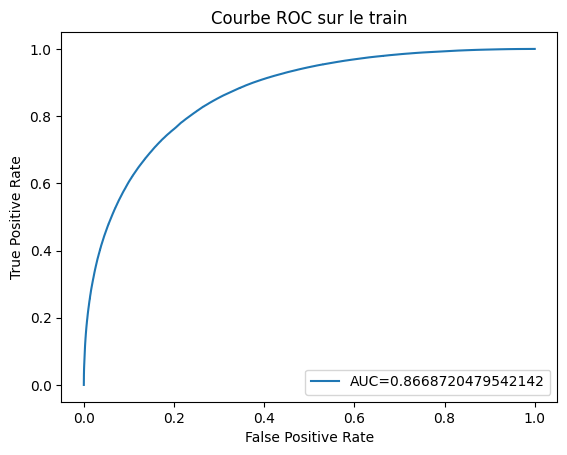

In [43]:
Utils.analyse_performance_model(model,X_train,y_train,"train")